In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import glob
import seaborn as sns
import matplotlib.dates as mdates
from pygam import LinearGAM, s
from datetime import datetime
import json 

import arviz as az
import pymc3 as pm
import patsy as pt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, matthews_corrcoef
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, MaxPool1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Classifiers
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from math import sqrt

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# DO NOT DELETE THIS CELL
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
MODELS_DIR = "models"
!mkdir -p $MODELS_DIR
        
def evaluate_model(model_name, y_test, y_predicted):
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    mape = mean_absolute_percentage_error(y_test, y_predicted)
    r_score = r2_score(y_test, y_predicted)
    corr_coeff = pearsonr(y_test, y_predicted)

    # Save model metrics
    metrics = {
        "Time": datetime.utcnow().isoformat(sep=' ', timespec='milliseconds'),
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape, 
        "Correlation Coeff": corr_coeff[0], 
        "R2 Score": r_score,
    }
    # Write to file
    with open(os.path.join(MODELS_DIR, model_name + "_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics))

In [5]:

# define my function for plotting my validation and loss history by epoch
# this function borrows heavily from the plot_history function provided
# in the Ex. 4 pre-lab for convolutional networks on Ed.

def plot_history(history_dict, title, test_eval=False,
                 loss_only=False, other_metric="accuracy"):
    """Plot training and validation loss and accuracy using keras history object
    """
    x_vals = np.arange(1, len(history_dict["loss"])+1)
    
    fig, ax = plt.subplots(1, 1 if loss_only else 2, figsize=(10, 4))

    plt.suptitle("{}".format(title), fontsize=16, y=1)
        
    if loss_only:
        
            ax.plot(x_vals, history_dict["loss"], "k--", label="train")
            ax.plot(x_vals, history_dict["val_loss"], "k-", label="test")
            ax.set_xlabel("epoch", fontsize=12)
            ax.set_ylabel("loss", fontsize=12)
            ax.set_xticks(x_vals)
            ax.grid(":", alpha=0.4)
            ax.tick_params(labelsize=10)        
    
    else:
        
        for i, metric in enumerate(["loss", other_metric]):
            ax[i].plot(
                x_vals, history_dict[metric], "k--",
                label="train"
            )
            ax[i].plot(
                x_vals, history_dict["val_{}".format(metric)], "k-",
                label="validation"
            )
            ax[i].set_xlabel("epoch", fontsize=14)
            ax[i].set_ylabel(metric, fontsize=14)
            ax[i].set_xticks(x_vals)
            ax[i].grid(":", alpha=0.4)
            ax[i].tick_params(labelsize=10)

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [6]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

In [7]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [8]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [9]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

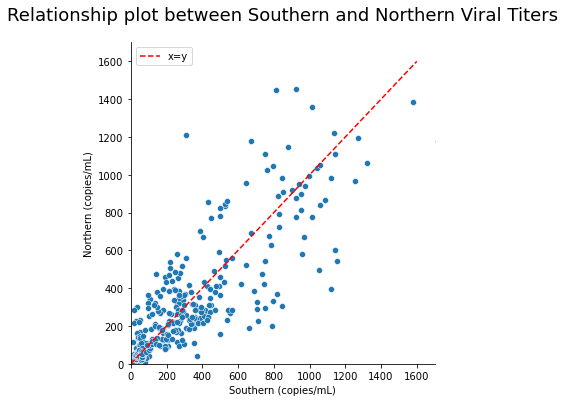

In [10]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

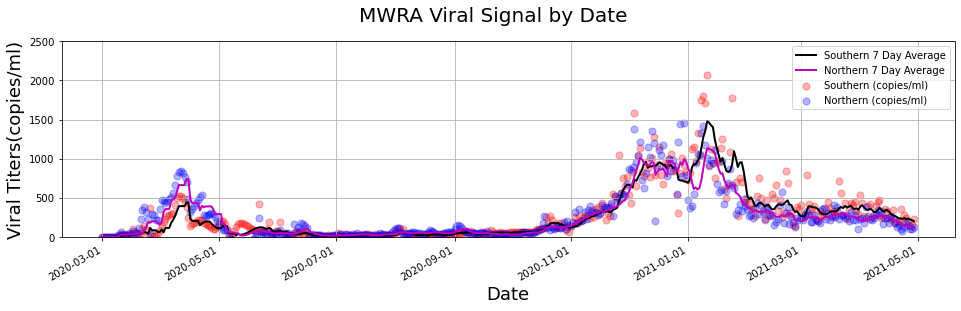

In [11]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [12]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [13]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [14]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [15]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


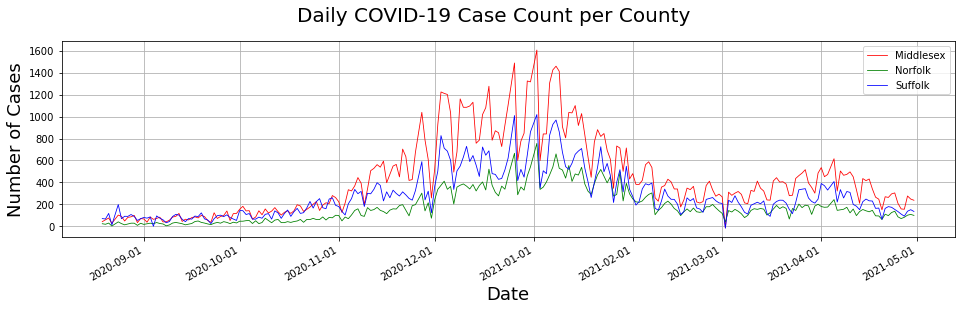

In [16]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [17]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135.0,16.0
1,2020-08-20,142.0,3.0
2,2020-08-21,221.0,3.0
3,2020-08-22,41.0,6.0
4,2020-08-24,340.0,13.0
...,...,...,...
245,2021-04-26,339.0,5.0
246,2021-04-27,329.0,1.0
247,2021-04-28,514.0,4.0
248,2021-04-29,507.0,5.0


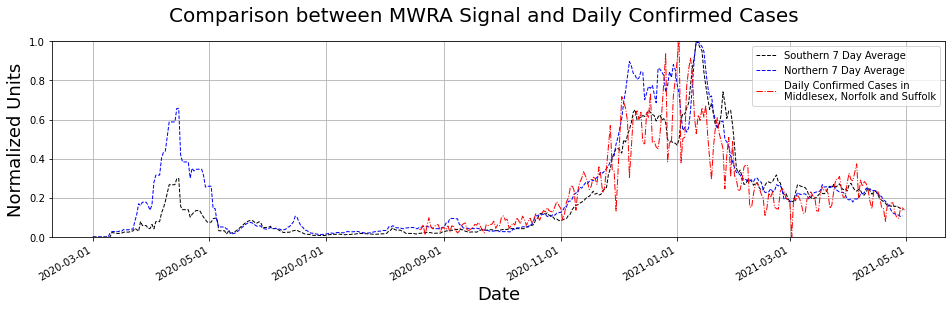

In [18]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [19]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern_Raw', 'Northern_Raw', 'Combined_Raw', 
                                              'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 
                                                'Southern_Variant', 'Northern_Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern_Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern_Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Combined_Raw'] = (row['Southern (copies/mL)'].to_list()[0] + row['Northern (copies/mL)'].to_list()[0]) / 2
        df_aligned.at[i, 'Southern_Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern_Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern_Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern_Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [20]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [21]:
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50.0,87.0,68.5,28.0,56.0,NaN,0,0,135.0,16.0,5.561524,0.659144
1,2020-08-20,43.068345,74.287119,58.677732,28.0,56.0,NaN,0,0,142.0,3.0,5.8499,0.123589
2,2020-08-21,35.0,60.0,47.5,35.0,61.0,NaN,0,0,221.0,3.0,9.104422,0.123589
3,2020-08-22,28.525255,49.594218,39.059737,35.0,61.0,NaN,0,0,41.0,6.0,1.689056,0.247179
4,2020-08-24,21.0,38.0,29.5,33.0,58.0,NaN,0,0,340.0,13.0,14.006802,0.535554


In [22]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases_Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths_Avg'] = df_aligned['Deaths'].rolling(window=7).mean()
# Also add average for southern and northern combined titers
df_aligned['Combined_Avg'] = df_aligned['Combined_Raw'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

In [23]:
# Finally normalize all values using MinMaxScaler
to_transform = ['Southern_Raw', 'Northern_Raw', 'Combined_Raw', 'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 'Cases', 'Deaths', 'Cases_Avg', 'Deaths_Avg', 'Cases_per_100K', 'Deaths_per_100K'] 
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[to_transform] = scaler.fit_transform(df_aligned[to_transform])
df_aligned = df_scaled
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases_Avg,Deaths_Avg
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,0.400,0.038211,0.400,0.014857,0.204301
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,0.075,0.040284,0.075,0.014857,0.204301
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,0.075,0.063685,0.075,0.014857,0.204301
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,0.150,0.010367,0.150,0.014857,0.204301
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,0.325,0.098934,0.325,0.014857,0.204301


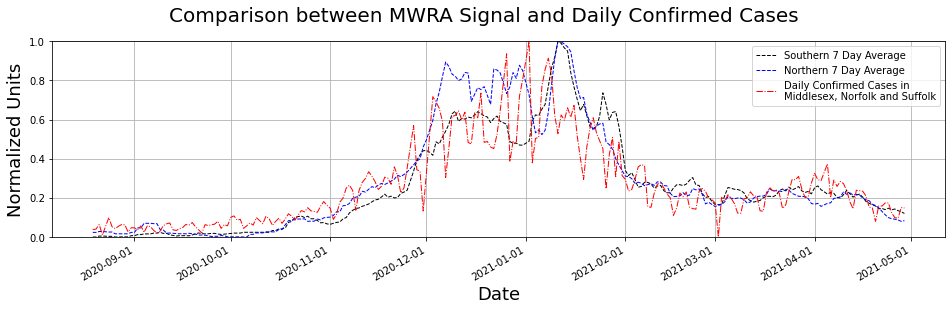

In [24]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases'].to_numpy(), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

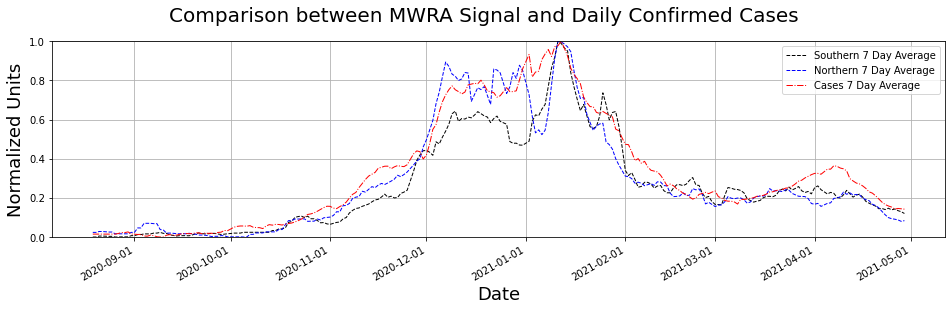

In [25]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

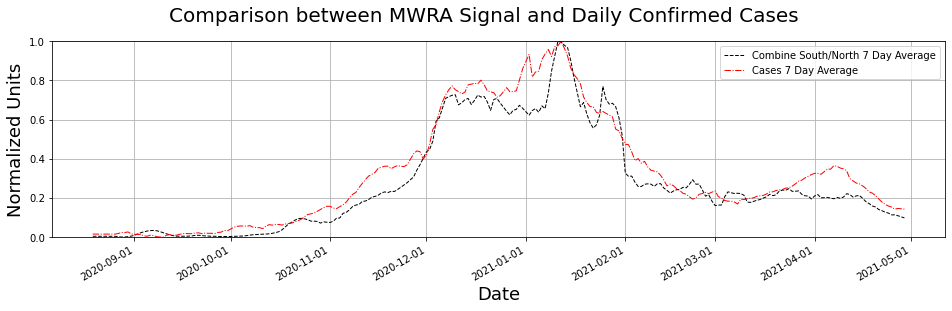

In [26]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Combined_Avg'].to_numpy(), '--k', linewidth = 1,  label="Combine South/North 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

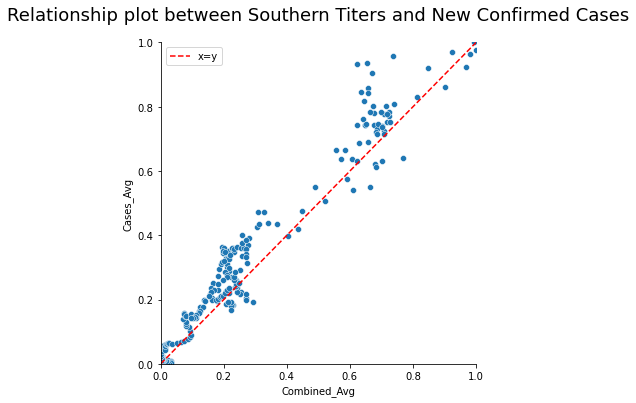

In [27]:
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Combined_Avg", y="Cases_Avg")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

In [28]:
# Create Lagged Dataset for Persistence Model
df_aligned['Cases_Avg(t-1)'] = df_aligned['Cases_Avg'].shift(1)
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases_Avg,Deaths_Avg,Cases_Avg(t-1)
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,0.400,0.038211,0.400,0.014857,0.204301,NaN
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,0.075,0.040284,0.075,0.014857,0.204301,0.014857
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,0.075,0.063685,0.075,0.014857,0.204301,0.014857
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,0.150,0.010367,0.150,0.014857,0.204301,0.014857
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,0.325,0.098934,0.325,0.014857,0.204301,0.014857


# Modeling


In [29]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model

In [30]:
# Create training and test labels for persistence model
X_train, y_train = df_train['Cases_Avg(t-1)'], df_train['Cases_Avg'],
X_test, y_test = df_test['Cases_Avg(t-1)'], df_test['Cases_Avg']

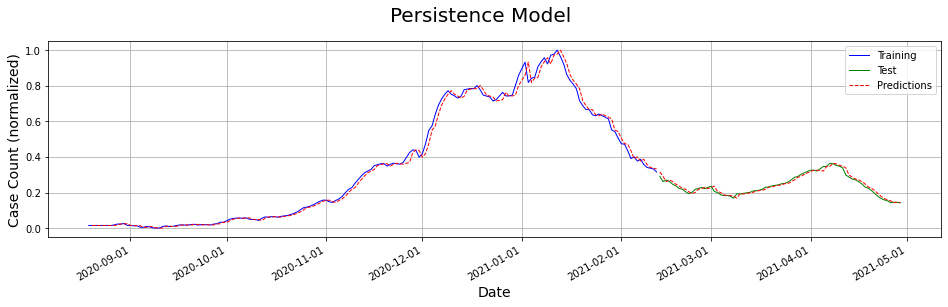

In [31]:
# plot persistence predictions and expected results
# The train_X and test_X are the predictions for the persistence model
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_train['Date'], X_train, '--r', linewidth = 1)
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], X_test, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [32]:
# Evaluated Model
# For persistence X_test values are the predictions
evaluate_model("Persistence", y_test, X_test)

# NEURAL NETWORKS

In [46]:
df_train['Cases_Avg(t-1)'] = df_train['Cases_Avg(t-1)'].fillna(0)
df_test['Cases_Avg(t-1)'] = df_test['Cases_Avg(t-1)'].fillna(0)

X_train = df_train[['Southern_Avg', 'Northern_Avg', 'Cases_Avg(t-1)']].astype('float').to_numpy()
y_train = df_train['Cases_Avg'].astype('float').to_numpy()

X_test = df_test[['Southern_Avg', 'Northern_Avg', 'Cases_Avg(t-1)']].astype('float').to_numpy()
y_test = df_test['Cases_Avg'].astype('float').to_numpy()

In [47]:
# GRUs and LSTMs expect a 3D input

def convert_dataset_3d (X, y, time_steps=1):
    X_values, y_values = [], []
    for i in range(len(X) - time_steps):
        X_values.append(X[i: i+time_steps, :])
        y_values.append(y[i+time_steps])
    return np.array(X_values), np.array(y_values)

TIME_STEPS = 7

X_train, y_train = convert_dataset_3d(X_train, y_train.reshape(-1,1), TIME_STEPS)
X_test, y_test = convert_dataset_3d(X_test, y_test.reshape(-1,1), TIME_STEPS)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (167, 7, 3)
y_train.shape:  (167, 1)
X_test.shape:  (68, 7, 3)
y_test.shape:  (68, 1)


In [48]:
# Hyperparameters
n_units_1 = 64
n_units_2 = 32

drop_rate = 0.1
batch_size = 8
epochs = 50
validation_split = 0.2
verbose = 1
optimizer = Adam(learning_rate = 0.0006)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Conv-1D Model

In [49]:
tf.keras.backend.clear_session()

# Define simple 1D CNN model
model_cnn = Sequential()

model_cnn.add(Conv1D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu', 
               input_shape=([X_train.shape[1], X_train.shape[2]])))
#model_cnn.add(MaxPool1D(pool_size = 2))
model_cnn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu'))

model_cnn.add(GRU(128, return_sequences = True, recurrent_dropout = 0.3))
model_cnn.add(GRU(64, recurrent_dropout = 0.3))

#model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation = 'relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(32, activation = 'relu'))
#model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            24704     
_________________________________________________________________
gru (GRU)                    (None, 3, 128)            99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [50]:
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_cnn.load_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "rb") as filehandler:
        history_cnn = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_cnn = history_cnn.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "wb") as filehandler:
        pickle.dump(history_cnn, filehandler)
    # save model weights for future use
    model_cnn.save_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 57ms/step - loss: 0.2348 - val_loss: 0.3843
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 0.1929 - val_loss: 0.3136
Epoch 3/50
17/17 [==============================] - 0s 21ms/step - loss: 0.1225 - val_loss: 0.2321
Epoch 4/50
17/17 [==============================] - 0s 20ms/step - loss: 0.1149 - val_loss: 0.1109
Epoch 5/50
17/17 [==============================] - 0s 21ms/step - loss: 0.0594 - val_loss: 0.0142
Epoch 6/50
17/17 [==============================] - 0s 21ms/step - loss: 0.0233 - val_loss: 0.0364
Epoch 7/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0317 - val_loss: 0.0149
Epoch 8/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0181 - val_loss: 0.0187
Epoch 9/50
17/17 [==============================] - 0s 21ms/step - loss: 0.0193 - val_loss: 0.0112
Epoch 10/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 11/

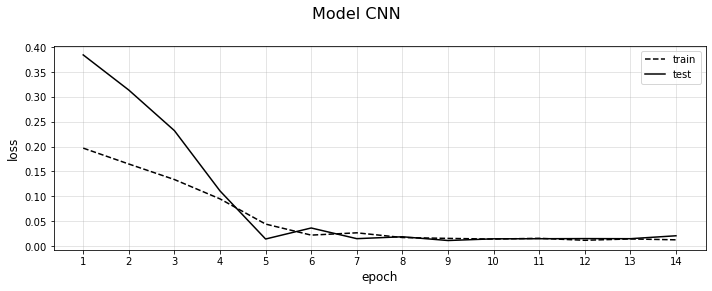

In [51]:
plot_history(history_cnn, "Model CNN", loss_only=True)

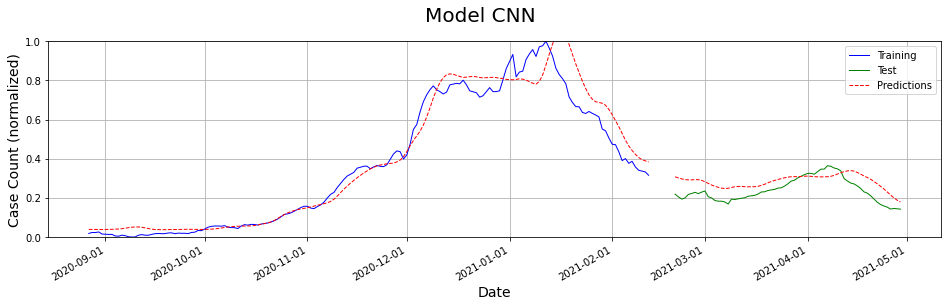

In [52]:
train_predictions = model_cnn.predict(X_train)
test_preds = model_cnn.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model CNN', fontsize=20, y=1.00)
fig.show()

In [53]:
# Evalute Model
evaluate_model("CNN", y_test.flatten(), test_preds.flatten())

# GRU Model

In [54]:


# Define GRU Model
model_gru = Sequential()
model_gru.add(tf.keras.layers.GRU(n_units_1, 
                                  return_sequences = True, 
                                  input_shape = [X_train.shape[1], X_train.shape[2]], 
                                  dropout = 0.0, recurrent_dropout = 0.3))
#model_gru.add(tf.keras.layers.Dropout(drop_rate))
model_gru.add(tf.keras.layers.GRU(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_gru.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile model
model_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7, 64)             13248     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,689
Trainable params: 22,689
Non-trainable params: 0
_________________________________________________________________


In [55]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_gru.load_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "rb") as filehandler:
        history_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_gru = model_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_gru = history_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_gru, filehandler)
    # save model weights for future use
    model_gru.save_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 59ms/step - loss: 0.0925 - val_loss: 0.1337
Epoch 2/50
17/17 [==============================] - 1s 35ms/step - loss: 0.0617 - val_loss: 0.0443
Epoch 3/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0269 - val_loss: 0.0121
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 5/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 6/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0074 - val_loss: 0.0094
Epoch 7/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0061 - val_loss: 0.0097
Epoch 8/50
17/17 [==============================] - 1s 35ms/step - loss: 0.0036 - val_loss: 0.0100
Epoch 9/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0034 - val_loss: 0.0113

...model weights and training history successfully saved to file.



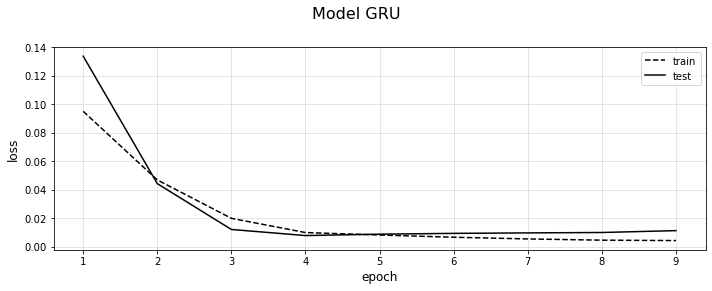

In [56]:
plot_history(history_gru, "Model GRU", loss_only=True)

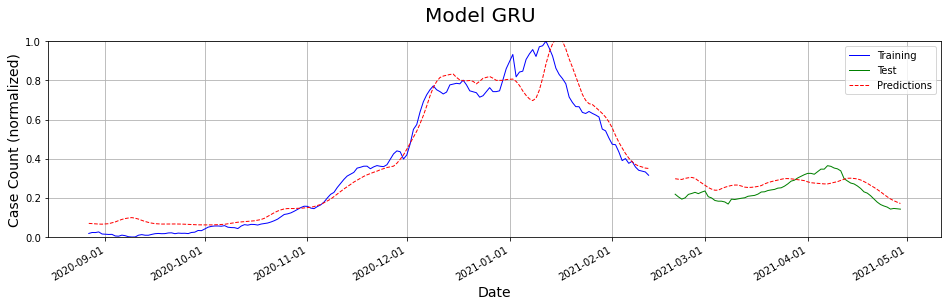

In [57]:
train_predictions = model_gru.predict(X_train)
test_preds = model_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model GRU', fontsize=20, y=1.00)
fig.show()

In [58]:
# Evalute Model
evaluate_model("GRU", y_test.flatten(), test_preds.flatten())

# LSTM 

In [59]:
# Define LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(n_units_1, return_sequences = True, 
                    input_shape = [X_train.shape[1], X_train.shape[2]], 
                    dropout = 0.0, recurrent_dropout = 0.3))
#model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(LSTM(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_lstm.add(Dense(1, activation='linear'))

# Compile model
model_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [60]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_lstm.load_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "rb") as filehandler:
        history_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_lstm = history_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_lstm, filehandler)
    # save model weights for future use
    model_lstm.save_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 61ms/step - loss: 0.1589 - val_loss: 0.2823
Epoch 2/50
17/17 [==============================] - 1s 37ms/step - loss: 0.1155 - val_loss: 0.1821
Epoch 3/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0781 - val_loss: 0.1057
Epoch 4/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0613 - val_loss: 0.0464
Epoch 5/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0250 - val_loss: 0.0186
Epoch 6/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0078 - val_loss: 0.0227
Epoch 8/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0059 - val_loss: 0.0256
Epoch 9/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0268
Epoch 10/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0059 - val_loss: 0.0277
Epoch 11/

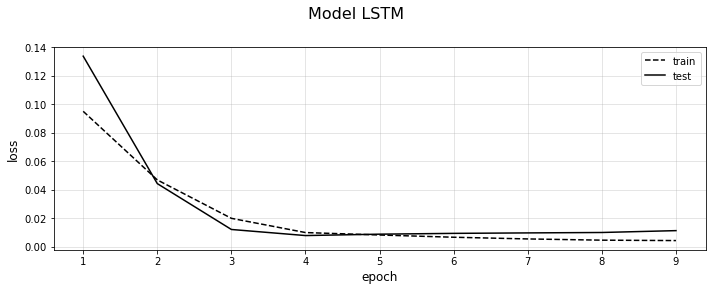

In [61]:
plot_history(history_gru, "Model LSTM", loss_only=True)

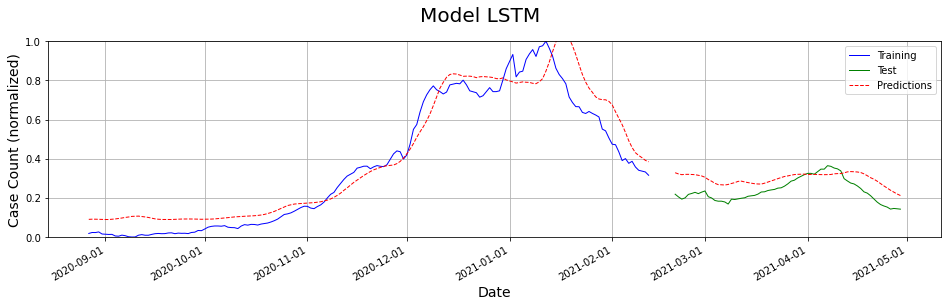

In [62]:
train_predictions = model_lstm.predict(X_train)
test_preds = model_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model LSTM', fontsize=20, y=1.00)
fig.show()

In [63]:
# Evalute Model
evaluate_model("LSTM", y_test.flatten(), test_preds.flatten())

# BiGRU

In [64]:
# Bidirectional GRU
model_bi_gru = Sequential()
model_bi_gru.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_gru.add(Bidirectional(GRU(n_units_1, return_sequences = True)))
model_bi_gru.add(tf.keras.layers.Dropout(drop_rate))
model_bi_gru.add(Bidirectional(GRU(n_units_2)))
model_bi_gru.add(Dense(1, activation='linear'))

# Compile model
model_bi_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 7, 128)            26496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 57,665
Trainable params: 57,665
Non-trainable params: 0
_________________________________________________________________


In [65]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_gru.load_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "rb") as filehandler:
        history_bi_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_gru = model_bi_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_gru = history_bi_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_gru, filehandler)
    # save model weights for future use
    model_bi_gru.save_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 61ms/step - loss: 0.2152 - val_loss: 0.2337
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.1128 - val_loss: 0.0531
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0302 - val_loss: 0.0132
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0158
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0158
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0163
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0172
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0172

...model weights and training history successfully saved to file.



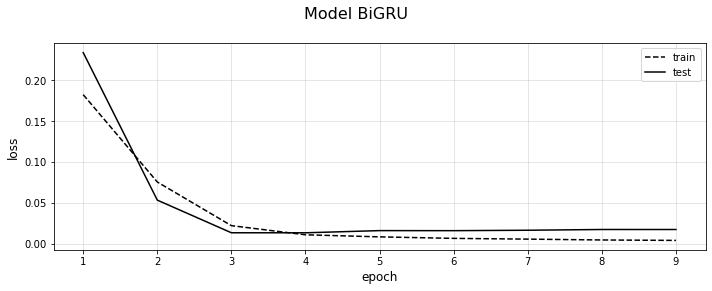

In [66]:
plot_history(history_bi_gru, "Model BiGRU", loss_only=True)

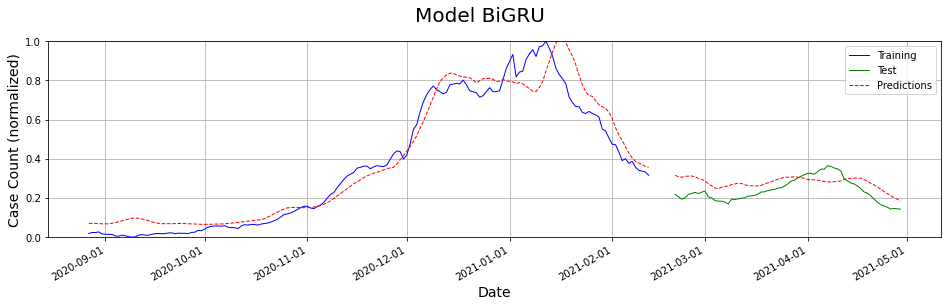

In [67]:
train_predictions = model_bi_gru.predict(X_train)
test_preds = model_bi_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiGRU', fontsize=20, y=1.00)
fig.show()

In [68]:
# Evalute Model
evaluate_model("BiGRU", y_test.flatten(), test_preds.flatten())

# Bi LSTM

In [69]:
# Define Bidirectional LSTM Model
model_bi_lstm = Sequential()
model_bi_lstm.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_lstm.add(Bidirectional(LSTM(n_units_1, return_sequences = True)))
model_bi_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_bi_lstm.add(Bidirectional(LSTM(n_units_2)))
model_bi_lstm.add(Dense(1, activation='linear'))

# Compile model
model_bi_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 7, 128)            34816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 76,097
Trainable params: 76,097
Non-trainable params: 0
_________________________________________________________________


In [70]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_lstm.load_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "rb") as filehandler:
        history_bi_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_lstm = model_bi_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_lstm = history_bi_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_lstm, filehandler)
    # save model weights for future use
    model_bi_lstm.save_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 90ms/step - loss: 0.2434 - val_loss: 0.2779
Epoch 2/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0876 - val_loss: 0.1320
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0688 - val_loss: 0.0404
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0220 - val_loss: 0.0104
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0191
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0194
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0199

...model weights and training history successfully saved to file.



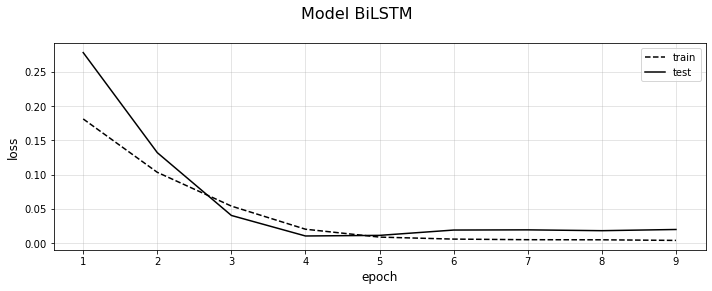

In [71]:
plot_history(history_bi_lstm, "Model BiLSTM", loss_only=True)

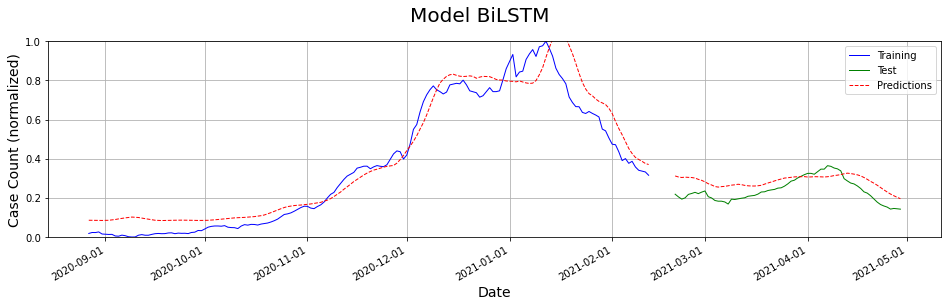

In [72]:
train_predictions = model_bi_lstm.predict(X_train)
test_preds = model_bi_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiLSTM', fontsize=20, y=1.00)
fig.show()

In [73]:
# Evalute Model
evaluate_model("BiLSTM", y_test.flatten(), test_preds.flatten())

# Show Validation Results

In [74]:
allModels = glob.glob(os.path.join(MODELS_DIR, "*.json"))
allData = []
for model_file in allModels:
    with open(model_file) as fp:
        model_data = json.load(fp)
        allData.append(model_data)

df_evaluation = pd.DataFrame.from_dict(allData)

In [75]:
df_evaluation.sort_values(by='RMSE', inplace=True)

def highlight_cols(s):
    if s.name in ["RMSE", "MAE", "MAPE"]:
        is_min_max = s == s.min()
    elif s.name in ['Correlation Coeff','R2 Score']:
        is_min_max = s == s.max()
    else:
        is_min_max = [False for _ in range(s.shape[0])]
    return ['background: lightgreen' if cell else '' for cell in is_min_max]

df_evaluation.style.apply(highlight_cols)

,Time,Model,RMSE,MAE,MAPE,Correlation Coeff,R2 Score
0,2021-05-08 04:25:57.255,Persistence,0.011971,0.009323,0.039842,0.978866,0.956400
2,2021-05-08 04:59:33.537,GRU,0.056403,0.051716,0.235868,0.617579,0.104086
1,2021-05-08 04:59:23.592,CNN,0.059922,0.054722,0.260264,0.786773,-0.011176
5,2021-05-08 05:00:01.135,BiLSTM,0.061293,0.055961,0.268733,0.787476,-0.057987
4,2021-05-08 04:59:52.719,BiGRU,0.062358,0.057232,0.267778,0.606814,-0.095056
3,2021-05-08 04:59:44.611,LSTM,0.073254,0.065903,0.320871,0.739390,-0.511209
